In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
#from sklearn import metrics
#import math

#import stuff for gradCAM
#import matplotlib.cm as cm
#from IPython.display import Image

#If nm,ultiople GPU, set which GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.3.2


In [2]:
# #code for GPU mem growth needed for EBG Laptop

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [3]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [4]:
#data
df = pd.read_csv('../data/SedMLdata.csv')
df.head()

,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,D90mm,D95mm,D98mm,skew,kurtosis
0,F1crop1.jpg,0.202,0.255,0.328,0.417,0.600,1.049,1.475,1.690,1.941,2.243,2.621,-0.310,0.992
1,F1crop2.jpg,0.168,0.194,0.224,0.256,0.305,0.481,0.974,1.420,2.143,2.982,3.980,0.298,0.965
2,F1crop3.jpg,0.128,0.144,0.160,0.176,0.198,0.304,0.540,0.700,0.897,1.172,1.598,0.247,0.857
3,F1crop4.jpg,0.218,0.273,0.346,0.429,0.621,1.283,1.821,2.040,2.241,2.532,2.873,-0.398,0.850
4,F1crop5.jpg,0.134,0.153,0.174,0.194,0.221,0.332,0.780,1.139,1.532,1.851,2.376,0.384,0.810


In [5]:
#build data generators for training and validaton

split = 0.2

df = pd.read_csv('../data/SedMLdata.csv')

columns=["D2mm", "D5mm", "D10mm", "D16mm",
"D25mm","D50mm", "D75mm", "D84mm", "D90mm",
"D95mm", "D98mm"]

loss_weighting = [0.1, 0.1, 0.1, 0.2, 0.5, 1, 0.5, 0.2, 0.1, 0.1, 0.1 ]

# Define dirs and files
train_data_dir = '../data/CropPics'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)


#set batch Size
batch_size = 8

#set color
# c_ch = 1
# c_mode = 'grayscale'
c_ch = 3
c_mode = 'rgb'

#set Image size (RGB so imshape is 3)
pix_dim = 1024
imsize = (pix_dim, pix_dim) 
imshape = (pix_dim, pix_dim, c_ch)

# Flow training images in batches 
train_generator = train_datagen.flow_from_dataframe(dataframe = df,
                                                    directory = train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'raw',
                                                    x_col = 'CropName',
                                                    y_col = columns,
                                                    target_size = imsize,
                                                    color_mode = c_mode,
                                                    subset = 'training')

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_dataframe(dataframe=df,
                                                          directory = train_data_dir,
                                                          batch_size = batch_size,
                                                          class_mode = 'raw',
                                                          x_col = 'CropName',
                                                          y_col = columns,
                                                          target_size = imsize,
                                                          color_mode = c_mode,
                                                          subset = 'validation')

Found 240 validated image filenames.
Found 60 validated image filenames.


Stats : [0.128 0.144 0.16  0.176 0.198 0.304 0.54  0.7   0.897 1.172 1.598]


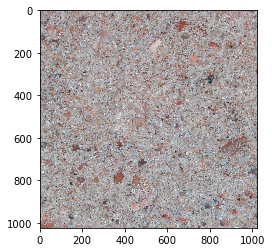

In [6]:
#show augs

how_many = 1
#how_many = batch size

x = validation_generator.next()

for i in range(0,how_many):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    plt.imshow(image.squeeze())   #squeeze for grayscale images
    print('Stats :', x[1][i])
    plt.show()

In [7]:
#model
baseFilter= 32

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=imshape),
    
    layers.SeparableConv2D(filters = baseFilter, kernel_size=3, padding='same', activation='relu'),
    layers.SeparableConv2D(baseFilter*2, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(baseFilter*3, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(baseFilter*4, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(baseFilter*5, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(baseFilter*6, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(baseFilter*7, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.GlobalMaxPooling2D(),
    #layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(columns), activation="linear")
])


model._name = "SandCam_CNN"

model.summary()


Model: "SandCam_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 1024, 1024, 32)    155       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 1024, 1024, 64)    2400      
_________________________________________________________________
batch_normalization (BatchNo (None, 1024, 1024, 64)    256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 512, 64)      0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 512, 512, 96)      6816      
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 512, 96)      384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 96)      

In [8]:
# define other metrics
metrics = tf.keras.metrics.MeanAbsolutePercentageError(name='mape')

In [9]:
#compile
#by plotting a loss curve, min occurs w/ Adam() at lr = 1e-2. but i am gettign better results by using default lr.

model.compile(loss='mean_squared_error', 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics = metrics, 
              loss_weights = loss_weighting
             )

In [10]:
# define a callback

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 20, 
                                             restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor = 0.2,
                                                 verbose = 1,
                                                 patience = 5)

In [12]:
#train the model
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs= 200,
                    workers = 8,
                    callbacks =[early_stop, reduce_lr])

Epoch 1/200
30/30 [==============================] - 43s 1s/step - loss: 0.2872 - mape: 347.4697 - val_loss: 0.1967 - val_mape: 96.6280
Epoch 2/200
30/30 [==============================] - 43s 1s/step - loss: 0.1060 - mape: 163.2780 - val_loss: 0.1908 - val_mape: 92.7053
Epoch 3/200
30/30 [==============================] - 41s 1s/step - loss: 0.0833 - mape: 129.1322 - val_loss: 0.1833 - val_mape: 87.0051
Epoch 4/200
30/30 [==============================] - 43s 1s/step - loss: 0.0751 - mape: 116.5877 - val_loss: 0.1765 - val_mape: 79.0306
Epoch 5/200
30/30 [==============================] - 42s 1s/step - loss: 0.0665 - mape: 113.7832 - val_loss: 0.1700 - val_mape: 71.9315
Epoch 6/200
30/30 [==============================] - 43s 1s/step - loss: 0.0629 - mape: 109.9417 - val_loss: 0.1634 - val_mape: 64.6531
Epoch 7/200
30/30 [==============================] - 42s 1s/step - loss: 0.0594 - mape: 100.0427 - val_loss: 0.1569 - val_mape: 59.3220
Epoch 8/200
30/30 [=============================

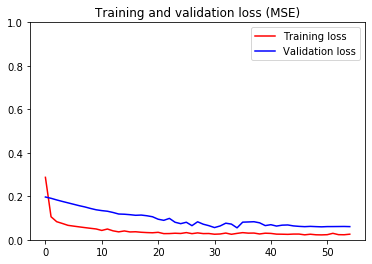

<Figure size 432x288 with 0 Axes>

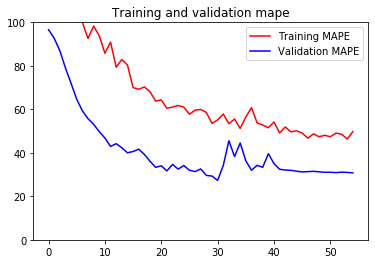

<Figure size 432x288 with 0 Axes>

In [13]:
#look at the metrics from training
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim(0,1)

plt.title('Training and validation loss (MSE)')
plt.legend(loc=0)
plt.figure()
plt.show()

mae = history.history['mape']
val_mae = history.history['val_mape']

plt.plot(epochs, mae, 'r', label='Training MAPE')
plt.plot(epochs, val_mae, 'b', label='Validation MAPE')
plt.ylim(0,100)

plt.title('Training and validation mape')
plt.legend(loc=0)
plt.figure()
plt.show()


Stats : [0.263 0.324 0.397 0.478 0.604 0.923 1.374 1.686 1.998 2.415 2.673]
Predicted Stats: [[0.2272429  0.32928023 0.35509035 0.3129752  0.43888813 0.5305891
  0.8029054  1.0160356  1.107535   1.6375732  2.0842009 ]]


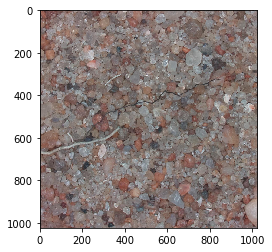

In [14]:
#Eventually, we will use model.evaluate() with the Duck Field samples... 
#until they are processed, we just use the validation egnerator as a sanity check

x = validation_generator.next()

how_many = 1
#how_many = batch_size

for i in range(0,how_many):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    #make a prediction
    img = np.expand_dims(image,axis=0)
    predStats = model.predict(img)
    
    plt.imshow(image.squeeze())   #squeeze for grayscale images  
    print('Stats :',x[1][i])
    print('Predicted Stats:', predStats)
    plt.show()

In [15]:
#save the model
filepath = './models/SNmodel_LW'
model.save(filepath)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/SNmodel_LW/assets


In [ ]:
model = tf.keras.models.load_model('./models/SNmodel_LW')


In [16]:
#post training quantization
#https://www.tensorflow.org/lite/performance/post_training_float16_quant

import pathlib

converter = tf.lite.TFLiteConverter.from_keras_model(model)

#dynamic range quant
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("TFL_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"SandCam_LW_quant_DR.tflite"
tflite_model_file.write_bytes(tflite_model)


#16 bits

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"SandCam_LW_quant_16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

!ls -lh {tflite_models_dir}

INFO:tensorflow:Assets written to: /tmp/tmpvdk4ymfe/assets
INFO:tensorflow:Assets written to: /tmp/tmpw0tnwy7x/assets


INFO:tensorflow:Assets written to: /tmp/tmpw0tnwy7x/assets


total 2.0M
-rw-rw-r-- 1 ebgoldstein ebgoldstein 635K Oct 26 16:27 SandCam_LW_quant_16.tflite
-rw-rw-r-- 1 ebgoldstein ebgoldstein 342K Oct 26 16:27 SandCam_LW_quant_DR.tflite
-rw-rw-r-- 1 ebgoldstein ebgoldstein 635K Oct 26 13:49 SandCam_quant_16.tflite
-rw-rw-r-- 1 ebgoldstein ebgoldstein 342K Oct 26 13:49 SandCam_quant_DR.tflite


In [17]:
#Load Quantized models
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()


Stats : [0.163 0.181 0.199 0.216 0.238 0.301 0.408 0.493 0.605 0.759 0.931]
Predicted Stats: [[0.19299291 0.21171653 0.24930583 0.24177554 0.3426019  0.3591572
  0.57739913 0.73219985 0.7985064  1.0840479  1.3914504 ]]


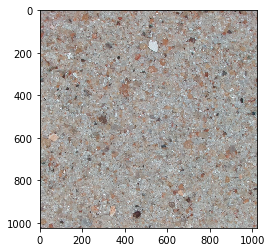

In [18]:
#Sanity check on image 
#again, Eventually, we will use a Duck Field samples... 

#SET THE IMAGE
Timage = validation_generator.next()
test_image = np.expand_dims(Timage[0][1],axis=0)

#dynamic range quant
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictionsDRQ = interpreter.get_tensor(output_index)

plt.imshow(Timage[0][1])

print('Stats :',Timage[1][1])
print('Predicted Stats:', predictionsDRQ)

plt.grid(False)


Stats : [0.163 0.181 0.199 0.216 0.238 0.301 0.408 0.493 0.605 0.759 0.931]
Predicted Stats: [[0.1966625  0.20621644 0.25277823 0.2447516  0.3456075  0.36734617
  0.58365667 0.7370153  0.7994937  1.0984496  1.4080951 ]]


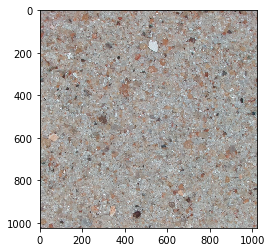

In [19]:
#16 bit quantization
input_index = interpreter_fp16.get_input_details()[0]["index"]
output_index = interpreter_fp16.get_output_details()[0]["index"]

interpreter_fp16.set_tensor(input_index, test_image)
interpreter_fp16.invoke()
predictionsf16 = interpreter_fp16.get_tensor(output_index)

plt.imshow(Timage[0][1])

print('Stats :',Timage[1][1])
print('Predicted Stats:', predictionsf16)


plt.grid(False)


In [ ]:
#Quant Aware Training

In [ ]:
#test Quantize